In [1]:
# ===== STEP 01: Setup & Data Load =====
!pip install --quiet pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# --- Create output folder (local, then push to GitHub) ---
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load dataset from Google Sheets (CSV export link) ---
# Your edit link:
# https://docs.google.com/spreadsheets/d/1VnJrIZvg_FiDcWRq_4KF5WRzvWuEnEJm/edit?usp=sharing
# Convert to CSV export:
SHEET_ID = "1VnJrIZvg_FiDcWRq_4KF5WRzvWuEnEJm"
csv_url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv"

# Low-memory off to avoid dtype warnings
df_raw = pd.read_csv(csv_url, low_memory=False)

print("Shape:", df_raw.shape)
df_raw.head()


Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [2]:
# ===== STEP 02: Standardize columns & basic cleaning =====
# Try to map various common names to standard RFM columns
col_map_candidates = {
    'invoiceno': ['InvoiceNo', 'Invoice', 'Invoice_No', 'InvoiceNumber'],
    'invoicedate': ['InvoiceDate', 'Invoice Date', 'Date'],
    'customerid': ['CustomerID', 'Customer Id', 'Customer_ID', 'Customer Code'],
    'quantity': ['Quantity', 'Qty', 'QTY'],
    'unitprice': ['UnitPrice', 'Unit Price', 'Price', 'Unit_Price'],
    'country': ['Country']
}

def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # Also try case-insensitive match
    lower_cols = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_cols:
            return lower_cols[c.lower()]
    return None

resolved = {}
for std_name, options in col_map_candidates.items():
    col = find_col(df_raw, options)
    resolved[std_name] = col

resolved


{'invoiceno': 'InvoiceNo',
 'invoicedate': 'InvoiceDate',
 'customerid': 'CustomerID',
 'quantity': 'Quantity',
 'unitprice': 'UnitPrice',
 'country': 'Country'}

In [3]:
# Ensure required columns exist (InvoiceNo, InvoiceDate, CustomerID, Quantity, UnitPrice)
required = ['invoiceno','invoicedate','customerid','quantity','unitprice']
missing = [k for k in required if resolved.get(k) is None]

if missing:
    raise ValueError(f"Missing required columns in the sheet for: {missing}\n"
                     f"Please rename columns in the Google Sheet to standard names like: "
                     f"{col_map_candidates}")

# Create a clean working copy with standardized names
df = pd.DataFrame({
    'InvoiceNo': df_raw[resolved['invoiceno']],
    'InvoiceDate': df_raw[resolved['invoicedate']],
    'CustomerID': df_raw[resolved['customerid']],
    'Quantity': pd.to_numeric(df_raw[resolved['quantity']], errors='coerce'),
    'UnitPrice': pd.to_numeric(df_raw[resolved['unitprice']], errors='coerce'),
})

# Optional (if present): Country
country_col = resolved.get('country')
if country_col is not None:
    df['Country'] = df_raw[country_col]
else:
    df['Country'] = np.nan

# Convert dates
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Remove invalids
df = df.dropna(subset=['InvoiceNo','InvoiceDate','CustomerID'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Remove canceled invoices (if InvoiceNo is string starting with 'C')
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C', na=False)]

# Monetary
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("After cleaning:", df.shape)
df.head()


/tmp/ipython-input-2718137554.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')


After cleaning: (397884, 7)


,InvoiceNo,InvoiceDate,CustomerID,Quantity,UnitPrice,Country,TotalPrice
0,536365,2010-12-01 08:26:00,17850.0,6,2.55,United Kingdom,15.30
1,536365,2010-12-01 08:26:00,17850.0,6,3.39,United Kingdom,20.34
2,536365,2010-12-01 08:26:00,17850.0,8,2.75,United Kingdom,22.00
3,536365,2010-12-01 08:26:00,17850.0,6,3.39,United Kingdom,20.34
4,536365,2010-12-01 08:26:00,17850.0,6,3.39,United Kingdom,20.34


In [4]:
# ===== STEP 03: RFM metrics =====
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

rfm = (df.groupby('CustomerID')
         .agg(Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
              Frequency=('InvoiceNo', 'nunique'),
              Monetary=('TotalPrice', 'sum'))
         .reset_index())

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [5]:
# ===== STEP 04: RFM scoring (1=worst, 5=best) =====
# Use quintiles. For Recency, lower is better → invert ranks.
# Guard against ties / constant columns by using rank then qcut.

def score_qcut(series, q=5, ascending=True):
    # Rank to break ties, then qcut into q bins
    ranked = series.rank(method='first', ascending=ascending)
    return pd.qcut(ranked, q, labels=range(1, q+1))

rfm['R_Score'] = score_qcut(rfm['Recency'], q=5, ascending=False).astype(int)  # recent → higher
rfm['F_Score'] = score_qcut(rfm['Frequency'], q=5, ascending=True).astype(int)
rfm['M_Score'] = score_qcut(rfm['Monetary'], q=5, ascending=True).astype(int)

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [6]:
# ===== STEP 05: Segment assignment rules =====
def segment_from_scores(r, f, m):
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    if r >= 4 and f >= 3:
        return 'Loyal Customers'
    if r <= 2 and f <= 2:
        return 'At Risk / Lost'
    if r >= 4 and f <= 2:
        return 'New Customers'
    if f >= 4 and m >= 3:
        return 'Potential Loyalist'
    if m >= 4 and f <= 2:
        return 'Big Spenders (Infrequent)'
    return 'Others'

rfm['Segment'] = rfm.apply(lambda x: segment_from_scores(x['R_Score'], x['F_Score'], x['M_Score']), axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,At Risk / Lost
1,12347.0,2,7,4310.00,5,5,5,555,Champions
2,12348.0,75,4,1797.24,2,4,4,244,Potential Loyalist
3,12349.0,19,1,1757.55,4,1,4,414,New Customers
4,12350.0,310,1,334.40,1,1,2,112,At Risk / Lost


In [7]:
# ===== STEP 06: Insights =====
segment_summary = (rfm
    .groupby('Segment')
    .agg(Customers=('CustomerID','nunique'),
         Avg_Recency=('Recency','mean'),
         Avg_Frequency=('Frequency','mean'),
         Avg_Monetary=('Monetary','mean'),
         Total_Monetary=('Monetary','sum'))
    .sort_values('Total_Monetary', ascending=False)
)

segment_summary


,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Monetary
Segment,,,,,
Champions,945,12.499471,11.157672,6077.304593,5743052.840
Potential Loyalist,564,84.992908,5.512411,2234.728282,1260386.751
Others,927,101.067961,1.976268,715.535330,663301.251
At Risk / Lost,1075,216.540465,1.101395,488.500755,525138.312
Loyal Customers,479,15.699374,2.964509,1091.146200,522659.030
New Customers,311,18.144695,1.244373,442.329389,137564.440
Big Spenders (Infrequent),37,55.162162,1.513514,1602.845405,59305.280


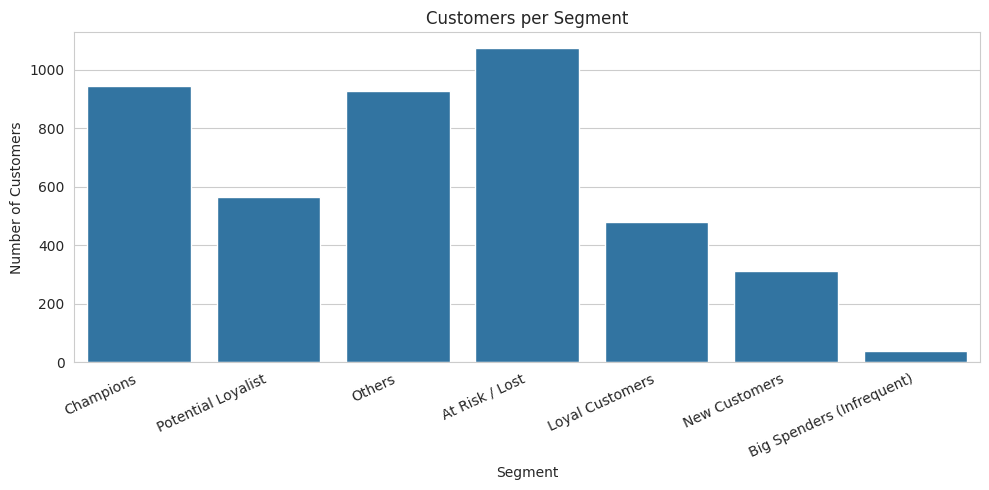

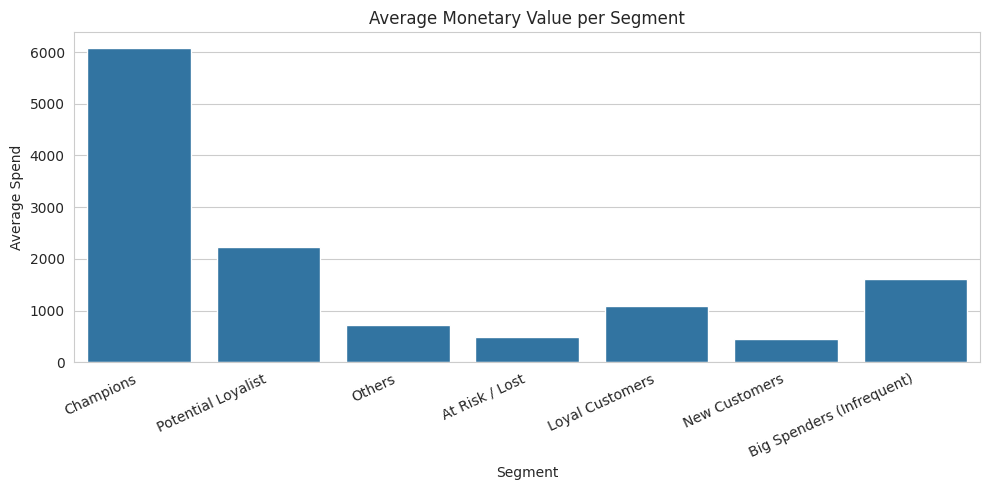

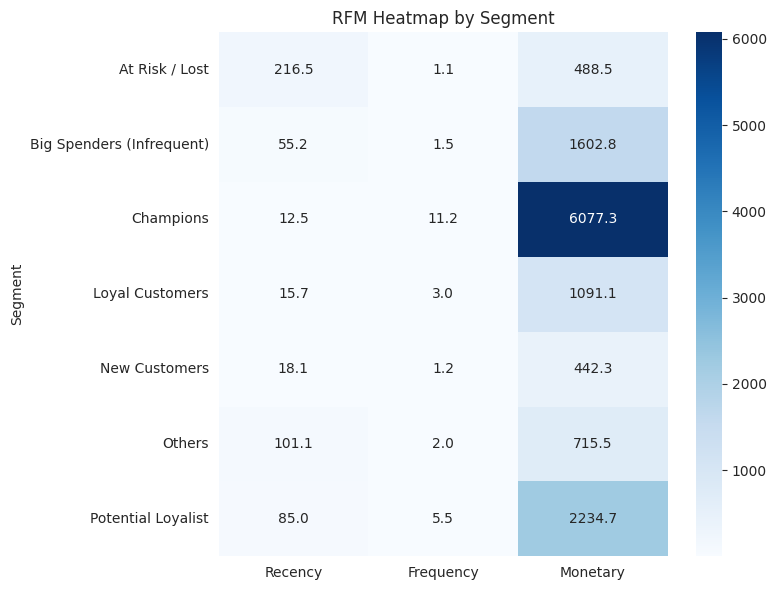

In [8]:
# ===== STEP 07: Visualizations =====
import matplotlib.ticker as mtick

# 1) Customer count per segment
plt.figure(figsize=(10,5))
ax = sns.barplot(x=segment_summary.index, y=segment_summary['Customers'], hue=None)
ax.set_title("Customers per Segment")
ax.set_ylabel("Number of Customers")
ax.set_xlabel("Segment")
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "segment_counts.png"), dpi=150)
plt.show()

# 2) Average Monetary per segment
plt.figure(figsize=(10,5))
ax = sns.barplot(x=segment_summary.index, y=segment_summary['Avg_Monetary'], hue=None)
ax.set_title("Average Monetary Value per Segment")
ax.set_ylabel("Average Spend")
ax.set_xlabel("Segment")
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "avg_monetary_per_segment.png"), dpi=150)
plt.show()

# 3) RFM heatmap (mean values by segment)
heatmap_data = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()
plt.figure(figsize=(8,6))
ax = sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Blues")
ax.set_title("RFM Heatmap by Segment")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "rfm_heatmap.png"), dpi=150)
plt.show()


In [9]:
# ===== STEP 08: Export CSVs =====
rfm_path = os.path.join(OUTPUT_DIR, "rfm_table.csv")
segments_path = os.path.join(OUTPUT_DIR, "customer_segments.csv")
summary_path = os.path.join(OUTPUT_DIR, "segment_summary.csv")

rfm.to_csv(rfm_path, index=False)
rfm[['CustomerID','Segment']].to_csv(segments_path, index=False)
segment_summary.reset_index().to_csv(summary_path, index=False)

print("Saved:")
print(" -", rfm_path)
print(" -", segments_path)
print(" -", summary_path)

# If running in Colab and you want quick downloads:
try:
    from google.colab import files
    files.download(rfm_path)
    files.download(segments_path)
    files.download(summary_path)
except Exception:
    pass


Saved:
 - output/rfm_table.csv
 - output/customer_segments.csv
 - output/segment_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# ===== STEP 09: Compact dashboard table =====
# Top segments by revenue + counts
dashboard = (segment_summary
             .reset_index()
             .rename(columns={
                 'Segment':'Segment',
                 'Customers':'#Customers',
                 'Avg_Recency':'Avg Recency (days)',
                 'Avg_Frequency':'Avg Frequency',
                 'Avg_Monetary':'Avg Monetary',
                 'Total_Monetary':'Total Monetary'
             }))

dashboard_path = os.path.join(OUTPUT_DIR, "rfm_dashboard.csv")
dashboard.to_csv(dashboard_path, index=False)
dashboard


,Segment,#Customers,Avg Recency (days),Avg Frequency,Avg Monetary,Total Monetary
0,Champions,945,12.499471,11.157672,6077.304593,5743052.840
1,Potential Loyalist,564,84.992908,5.512411,2234.728282,1260386.751
2,Others,927,101.067961,1.976268,715.535330,663301.251
3,At Risk / Lost,1075,216.540465,1.101395,488.500755,525138.312
4,Loyal Customers,479,15.699374,2.964509,1091.146200,522659.030
5,New Customers,311,18.144695,1.244373,442.329389,137564.440
6,Big Spenders (Infrequent),37,55.162162,1.513514,1602.845405,59305.280
